# Conditional Autoencoder

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

In [30]:
img_dim = 28
latent_dim = 3
dropout_rate = 0.3
learn_rate_init = 0.0001

def apply_bn_and_dropout(x):
    return layers.Dropout(dropout_rate)(layers.BatchNormalization()(x))

def make_encoder(input_dim: int, latent_dim: int, num_classes: int):
    input_img = keras.Input(shape=(input_dim, input_dim, 1))
    flatt_img = layers.Flatten()(input_img)
    input_lbl = keras.Input(shape=(num_classes,), dtype='float32')

    x = layers.concatenate([flatt_img, input_lbl])
    x = layers.Dense(256, activation='relu')(x)
    x = apply_bn_and_dropout(x)
    x = layers.Dense(128, activation='relu')(x)
    x = apply_bn_and_dropout(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model([input_img, input_lbl], [z_mean, z_log_var, z], name="encoder")
    encoder.summary()
    return encoder

def make_decoder(output_dim: int, latent_dim: int, num_classes: int):
    latent_inputs = keras.Input(shape=(latent_dim,))
    input_lbl = keras.Input(shape=(num_classes,), dtype='float32')
    x = layers.concatenate([latent_inputs, input_lbl])
    x = layers.Dense(128, activation='relu')(x)
    x = apply_bn_and_dropout(x)
    x = layers.Dense(256, activation='relu')(x)
    x = apply_bn_and_dropout(x)
    x = layers.Dense(28 * 28, activation='sigmoid')(x)
    decoder_outputs = layers.Reshape((output_dim, output_dim, 1))(x)
    decoder = keras.Model([latent_inputs, input_lbl], decoder_outputs, name="decoder")
    decoder.summary()
    return decoder

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class CVAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        
        img, lbl = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data[0])
            reconstruction = self.decoder([z, lbl])
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(img, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [31]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

y_train_cat = keras.utils.to_categorical(y_train).astype(np.float32)
y_test_cat = keras.utils.to_categorical(y_test).astype(np.float32)
num_calsses = y_train_cat.shape[1]

mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
class_lbls_digits = np.concatenate([y_train_cat, y_test_cat], axis=0)

x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test  = np.expand_dims(x_test, -1).astype("float32") / 255

encoder = make_encoder(img_dim, latent_dim, num_calsses)
decoder = make_decoder(img_dim, latent_dim, num_calsses)
cvae = CVAE(encoder, decoder)
cvae.compile(optimizer=keras.optimizers.Adam(learn_rate_init))


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 flatten_4 (Flatten)            (None, 784)          0           ['input_17[0][0]']               
                                                                                                  
 input_18 (InputLayer)          [(None, 10)]         0           []                               
                                                                                                  
 concatenate_8 (Concatenate)    (None, 794)          0           ['flatten_4[0][0]',              
                                                                  'input_18[0][0]']         

In [32]:
def plot_label_clusters_2d(cvae, imgs, labels, epoch: int = 1):
    # display a 2D plot of the digit classes in the latent space
    digits = np.argmax(labels, axis=-1)
    z_mean, _, _ = cvae.encoder.predict([imgs, labels])
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=digits)
    plt.colorbar()
    plt.xlabel("z0")
    plt.ylabel("z1")
    plt.title(f'Epoch: {epoch}')
    plt.xlim(-5.5, 5.5)
    plt.ylim(-5.5, 5.5)
    plt.savefig(f'figs/cvae/2d/{epoch}.png')
    plt.close()
    #plt.show()

def plot_label_clusters_3d(cvae, imgs, labels, epoch):
    # display a 3D plot of the digit classes in the latent space
    digits = np.argmax(labels, axis=-1)
    z_mean, _, _ = cvae.encoder.predict([imgs, labels])
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(projection='3d')
    
    scatter = ax.scatter(z_mean[:, 0], z_mean[:, 1], z_mean[:, 2], c=digits)
    cbar = plt.colorbar(scatter)
    
    ax.set_xlabel("z0")
    ax.set_ylabel("z1")
    ax.set_zlabel("z2")
    ax.set_title(f'Epoch: {epoch}')
    ax.set_xlim(-5.5, 5.5)
    ax.set_ylim(-5.5, 5.5)
    ax.set_zlim(-5.5, 5.5)
    plt.savefig(f'figs/cvae/3d/{epoch}.png')
    plt.close()

def on_epoch_end(epoch, logs):
    plot_label_clusters_2d(cvae, x_train, y_train_cat, epoch)
    plot_label_clusters_3d(cvae, x_train, y_train_cat, epoch)

save_fig = keras.callbacks.LambdaCallback(on_epoch_end=on_epoch_end)
tb       = keras.callbacks.TensorBoard(log_dir='logs_cvae')

In [33]:
cvae.fit(
    [mnist_digits, class_lbls_digits], 
    epochs=50, 
    batch_size=500, 
    callbacks=[save_fig, tb]
)


Epoch 1/50
140/140 [==============================] - 9s 59ms/step - loss: 475.0918 - reconstruction_loss: 359.5593 - kl_loss: 22.8638
Epoch 2/50
140/140 [==============================] - 8s 59ms/step - loss: 229.7430 - reconstruction_loss: 208.1423 - kl_loss: 13.4436
Epoch 3/50
140/140 [==============================] - 8s 57ms/step - loss: 205.6197 - reconstruction_loss: 193.5072 - kl_loss: 8.1322
Epoch 4/50
140/140 [==============================] - 10s 74ms/step - loss: 189.8298 - reconstruction_loss: 179.7535 - kl_loss: 7.4472
Epoch 5/50
140/140 [==============================] - 13s 91ms/step - loss: 180.7258 - reconstruction_loss: 172.7992 - kl_loss: 6.3570
Epoch 6/50
140/140 [==============================] - 10s 75ms/step - loss: 174.3262 - reconstruction_loss: 167.3901 - kl_loss: 5.7954
Epoch 7/50
140/140 [==============================] - 9s 65ms/step - loss: 168.9987 - reconstruction_loss: 162.4580 - kl_loss: 5.5671
Epoch 8/50
140/140 [==============================] - 9s 

In [34]:
import glob
import imageio

fps = 1.5
duration = 500 # ms
figs2d = sorted(glob.glob('figs/cvae/2d/*.png'), key=lambda s: int(s.rstrip('.png').split('/')[-1]))
figs3d = sorted(glob.glob('figs/cvae/3d/*.png'), key=lambda s: int(s.rstrip('.png').split('/')[-1]))

with imageio.get_writer(f'figs/cvae/2d/movie_fps={fps:.2f}.gif', mode='I', fps=fps) as writer:
    for fig in figs2d:
        image = imageio.imread(fig)
        writer.append_data(image)

with imageio.get_writer(f'figs/cvae/3d/movie_fps={fps:.2f}.gif', mode='I', fps=fps) as writer:
    for fig in figs3d:
        image = imageio.imread(fig)
        writer.append_data(image)

/home/denys/anaconda3/envs/py3D/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  # This is added back by InteractiveShellApp.init_path()
/home/denys/anaconda3/envs/py3D/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  app.launch_new_instance()


In [47]:
from scipy.stats import norm 

n = 10 # number of images to generate

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))



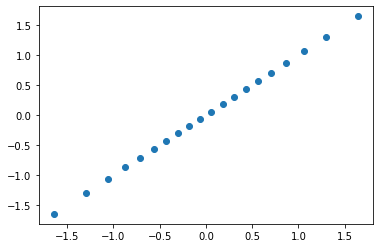

In [46]:
plt.scatter(grid_x, grid_y)
plt.show()

In [50]:
figure = np.zeros((img_dim * n, img_dim * n))

for i, yi in enumerate(grid_y):
    for i, xi in enumerate(grid_x):
        z_sample = np.zeros((1, latent_dim))
        z_sample[:, :2] = np.array([[xi, yi]])

        x_decoded = cvae.decoder.predict(z_sample)
        digit = x_decoded[0].squeeze()
        figure[i * img_dim : (i + 1) * img_dim,
                j * img_dim : (j + 1) * img_dim] = digit

plt.figure(figsize=(15, 15))
plt.imshow(figure, cmap='Greys_r')
plt.grid(None)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)        
plt.show()


NameError: name 'generator' is not defined